In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#read data
data = pd.read_csv("IMDB Dataset.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
# checking first 5 rows of the dataset
data.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
# checking sample review
data.review.iloc[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
data.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [9]:
train = data.iloc[0:40000].copy(deep=True)  # train dataset
test = data.iloc[40000:].copy(deep=True)    # test dataset

In [10]:
print(train.shape)
print(test.shape)

(40000, 2)
(10000, 2)


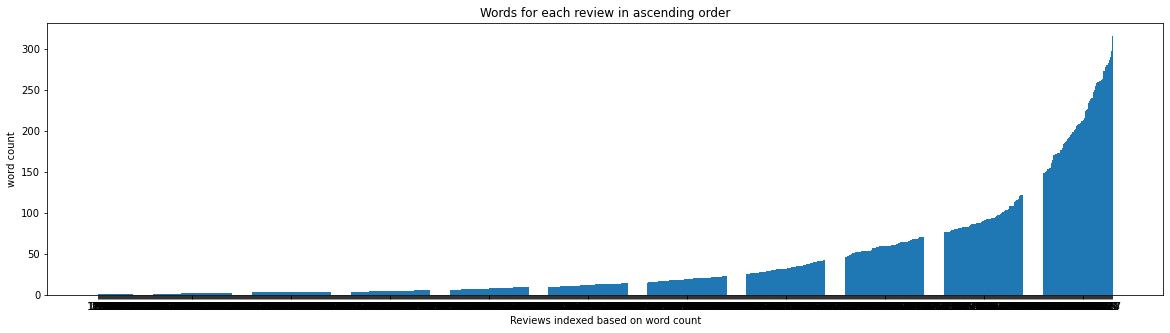

In [11]:
word_count = train['review'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('word count')
plt.xlabel('Reviews indexed based on word count')
plt.title('Words for each review in ascending order')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

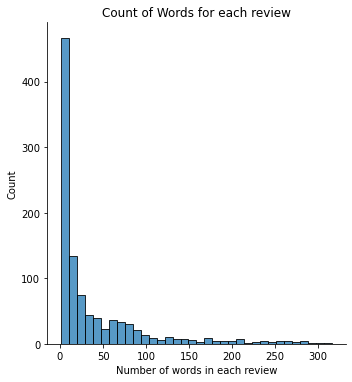

In [12]:
sns.displot(word_count.values)
plt.title('Count of Words for each review')
plt.xlabel('Number of words in each review')
plt.show()


In [13]:
positive_word_count = train[train['sentiment']=='positive']['review'].str.split().apply(len)
positive_word_count = positive_word_count.values

negative_word_count = train[train['sentiment']=='negative']['review'].str.split().apply(len)
negative_word_count = negative_word_count.values

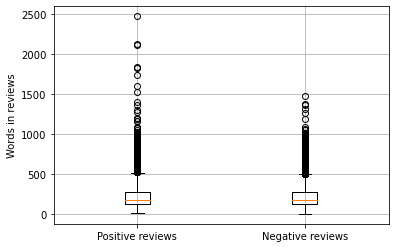

In [14]:
plt.boxplot([positive_word_count, negative_word_count])
plt.xticks([1,2],('Positive reviews','Negative reviews'))
plt.ylabel('Words in reviews')
plt.grid()
plt.show()

In [15]:


def decontract_words(text):
    '''
    input: takes text as input which can have words such as won't, can't, shouldn't etc
    output: return the text by decontracting the words won't to would not, shouldn't to should not etc.
    '''
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    return text



def removePunctuation(text):
    '''
    input : takes text as input and removes special characters like  @, ?, ! etc.
    '''
    cleanedText = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    cleanedText = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleanedText)
    cleanedText = re.sub(r'\s+', ' ', cleanedText, flags=re.I)
    cleanedText = re.sub(r'[^A-Za-z]+',' ',cleanedText)
    cleanedText = re.sub(r'[?|!|\'|"|#|+|@|)|(]', r' ', cleanedText) 
    cleanedText = re.sub(r'[.|,|)|(|\|/]', r' ', cleanedText)
    cleanedText = re.sub(r'[*|&|=|$|%|+|@|)|(]', r' ', cleanedText) 
    cleanedText = re.sub(r'[,|;|:|}|{|-|_|£]', r' ', cleanedText) 
    cleanedText = cleanedText.lower() # all the words are then converted to lower case and then finally returned
    return cleanedText

In [16]:
# row 2 review before preprocessing
train.review.iloc[2] 

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [17]:
train.loc[:,'review'] = train.review.apply(decontract_words) 
train.loc[:,'review'] = train.review.apply(removePunctuation)

In [18]:
# row 2 review after decontracting, removing punctuations and converting all words to lower case
train.review.iloc[2] 

'i thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love br br this was the most would laughed at one of woody is comedies in years dare say decade while have never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman br br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends '

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ShashiKant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'it', 'no', 'these', "aren't", 'don', 'should', 'then', 've', 'as', 'are', 'being', 'so', 'such', 'my', 'who', 'other', 'on', 'you', 'been', 'i', "you'll", "won't", 'does', 'ours', 'into', 'after', 'until', 'own', 'our', 'needn', 'against', 'between', "needn't", 'shan', 'his', "should've", "hadn't", 'have', 'about', 'had', 'they', 'more', 'o', 'hasn', 'what', 'myself', 'ourselves', 'but', 'itself', 'here', 'themselves', 'out', 'mightn', 'at', 'over', "mustn't", 'she', 'if', 'of', 'before', 'doesn', 'we', 'theirs', "she's", 'that', 'were', 'shouldn', 'its', "you're", 'most', 'nor', 'very', 'did', 'each', "shouldn't", 'for', 'all', 'ain', 'be', 'in', "didn't", 'there', 'this', 'from', 'him', 'your', "you've", 'he', 'below', "don't", "it's", 'is', 'not', 'was', 'too', 'and', "hasn't", 'am', 'down', 'during', 'aren', 'her', 'only', 'few', 'again', 'herself', 'or', "that'll", 'weren', 'a', 'the', 'because', 'has', 'couldn', 'y', "haven't", 'by', "wouldn't", 'while', 'haven', 'hers', 'do', 

In [20]:
# words like no and not are commonly occur in negative reviews hence will remove these stop words from the 
# stop words set
stop_words.remove('no')
stop_words.remove('not')
#adding commonl occuring html tags in stop words
stop_words.add('br')
stop_words.add('html')
stop_words.add('b')
stop_words.add('hr')
stop_words.add('link')
stop_words.add('p')

In [21]:
def remove_stop_words(text):
    '''
    input: takes text as an input and checks for all stop words present in the text
    output: return the text without stop words
    '''
    word_token = word_tokenize(text)
    filtered_text = [word for word in word_token if not word in stop_words]
    return ' '.join(filtered_text)

In [22]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
nltk.download('wordnet')
nltk.download('omw-1.4')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV


def lemmatize_text(text):
    '''
    input: takes text as input and converts/ lemmatize all the words in that text
    output: return text with all the words converted to their corresponding lemma
    '''
    word_token = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for token, tag in pos_tag(word_token):
        lemma = lemmatizer.lemmatize(token, tag_map[tag[0]])
        lemmatized_words.append(lemma)
        
    return ' '.join(lemmatized_words)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ShashiKant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ShashiKant\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
train.review.iloc[2] 

'i thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point risk addiction thought it was proof that woody allen is still fully in control of the style many of us have grown to love br br this was the most would laughed at one of woody is comedies in years dare say decade while have never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into average but spirited young woman br br this may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman great comedy to go see with friends '

In [24]:
nltk.download('punkt')
train.loc[:,'review'] = train.review.apply(remove_stop_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ShashiKant\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
train.review.iloc[2] 

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize not match point risk addiction thought proof woody allen still fully control style many us grown love would laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may not crown jewel career wittier devil wears prada interesting superman great comedy go see friends'

In [26]:
nltk.download('averaged_perceptron_tagger')
train.loc[:,'review'] = train.review.apply(lemmatize_text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ShashiKant\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [27]:
train.review.iloc[2] 

'think wonderful way spend time hot summer weekend sit air condition theater watch light hearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize not match point risk addiction think proof woody allen still fully control style many u grown love would laugh one woody comedies year dare say decade never impress scarlet johanson manage tone sexy image jump right average spirit young woman may not crown jewel career witty devil wear prada interest superman great comedy go see friend'

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(train['review'].values)

train_bow = vectorizer.transform(train['review'].values)

print("After vectorizations")
print(train_bow.shape)

After vectorizations
(40000, 5000)


In [29]:
# encoding y label, encoding positive to 1 and negative to 0
y_train = train.sentiment.map(dict(positive=1, negative=0))

In [30]:
# similarly preparing test data
test.loc[:,'review'] = test.review.apply(decontract_words) 
test.loc[:,'review'] = test.review.apply(removePunctuation)
test.loc[:,'review'] = test.review.apply(remove_stop_words)
test.loc[:,'review'] = test.review.apply(lemmatize_text)

test_bow = vectorizer.transform(test['review'].values)

print("After vectorizations and preprocessing of test data:")
print(test_bow.shape)

After vectorizations and preprocessing of test data:
(10000, 5000)


In [31]:
y_test = test.sentiment.map(dict(positive=1, negative=0))

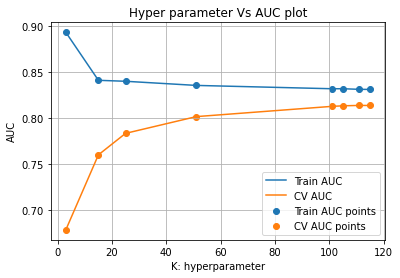

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 15, 25, 51, 101, 105, 111, 115]}

grid_classifier = GridSearchCV(knn_classifier, parameters, cv=3, scoring='roc_auc', return_train_score=True)
grid_classifier.fit(train_bow, y_train)

results = pd.DataFrame.from_dict(grid_classifier.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [33]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.212104,0.123950,36.526374,5.451582,3,{'n_neighbors': 3},0.675798,0.676212,0.683549,0.678520,0.003561,8,0.890036,0.890164,0.898609,0.892936,0.004011
1,0.050200,0.008970,34.849355,0.784405,15,{'n_neighbors': 15},0.764724,0.761439,0.753686,0.759950,0.004628,7,0.843513,0.845407,0.833493,0.840804,0.005227
2,0.059509,0.015046,38.807269,1.885088,25,{'n_neighbors': 25},0.786344,0.785617,0.777836,0.783266,0.003851,6,0.839925,0.844523,0.834796,0.839748,0.003973
3,0.050201,0.004631,37.173304,2.667887,51,{'n_neighbors': 51},0.803397,0.800416,0.800421,0.801411,0.001404,5,0.830964,0.839865,0.834969,0.835266,0.003640
4,0.052194,0.007388,37.721518,2.277512,101,{'n_neighbors': 101},0.817541,0.806081,0.814045,0.812556,0.004795,4,0.829470,0.833048,0.832413,0.831644,0.001559
5,0.040896,0.000819,34.904199,2.254011,105,{'n_neighbors': 105},0.818486,0.805890,0.814995,0.813124,0.005310,3,0.830291,0.832701,0.832006,0.831666,0.001013
6,0.042565,0.002052,39.815624,4.662059,111,{'n_neighbors': 111},0.818809,0.806647,0.815267,0.813574,0.005107,1,0.829255,0.831995,0.831761,0.831004,0.001241
7,0.044895,0.006461,35.551776,3.108388,115,{'n_neighbors': 115},0.819116,0.806178,0.815177,0.813490,0.005415,2,0.829402,0.831613,0.831777,0.830930,0.001083


In [34]:
# from the results, it was observed that best k is 111

best_k = 111

In [35]:
from sklearn.metrics import roc_curve, auc

knn_clf = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn_clf.fit(train_bow, y_train)

y_train_pred = knn_clf.predict_proba(train_bow)[:,1] 
y_test_pred = knn_clf.predict_proba(test_bow)[:,1]

In [36]:
y_train.shape

(40000,)

In [37]:
y_train_pred.shape

(40000,)

In [38]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

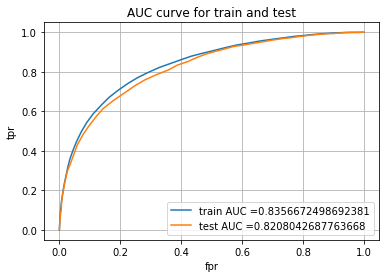

In [39]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("AUC curve for train and test")
plt.grid()
plt.show()

In [40]:
def find_best_threshold(threshould, fpr, tpr):
    '''
    input: takes threshould, fpr, tpr from roc curve results and try to find the best threshould for which fpr will be least
    output : return the best threshould value
    '''
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    '''
    input: takes the predict_proba values of test data and best threshould
    output: return the prediction based on probabilities and choosed best threshould
    '''
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.5741605253346643 for threshold 0.541
Train confusion matrix


<AxesSubplot:>

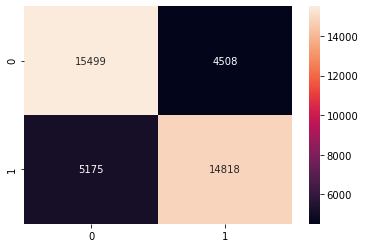

In [41]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
train_confusion_mat = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(train_confusion_mat, annot=True, fmt='d')

Test confusion matrix


<AxesSubplot:>

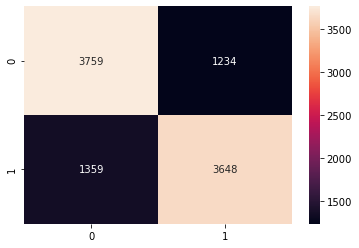

In [42]:
print("Test confusion matrix")
test_confusion_mat = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(test_confusion_mat, annot=True, fmt='d')

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_aprf_scores(y_true, y_pred):
    '''
    input: ground truth and predicted value of those ground truths
    output: print accuracy,precison, recall and f1 score
    '''
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision score: {precision_score(y_true, y_pred)}')
    print(f'Recall score: {recall_score(y_true, y_pred)}')
    print(f'F1 score: {f1_score(y_true, y_pred)}')

print_aprf_scores(y_test, predict_with_best_t(y_test_pred, best_t))

Accuracy: 0.7407
Precision score: 0.7472347398607129
Recall score: 0.7285799880167765
F1 score: 0.7377894630397411


In [44]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

print(f'ROC score: {roc_auc_score(y_test,y_test_pred)}')
print(f'log loss: {log_loss(y_test, predict_with_best_t(y_test_pred, best_t))}')
print(f'brier score loss: {brier_score_loss(y_test, predict_with_best_t(y_test_pred, best_t))}')

ROC score: 0.8208042687763668
log loss: 8.956003389523227
brier score loss: 0.2593


# Apply Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")



lr_classifier = LogisticRegression(penalty='l2', solver='saga' )
parameters = {
              'C' : [0.001, 0.01, 0.1, 1, 10, 100]}

grid_classifier = GridSearchCV(lr_classifier, parameters, cv=3, scoring='roc_auc', return_train_score=True)
grid_classifier.fit(train_bow, y_train)

results = pd.DataFrame.from_dict(grid_classifier.cv_results_)


In [46]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.504244,0.202774,0.342404,0.366919,0.001,{'C': 0.001},0.926755,0.921952,0.922386,0.923698,0.002169,6,0.932141,0.933404,0.933917,0.933154,0.000746
1,4.341007,0.336711,0.027817,0.021737,0.01,{'C': 0.01},0.949177,0.945856,0.946123,0.947052,0.001507,5,0.966579,0.966895,0.967632,0.967035,0.000441
2,4.110416,0.113962,0.028552,0.019518,0.1,{'C': 0.1},0.952462,0.949331,0.949405,0.950399,0.001459,1,0.976561,0.976780,0.979650,0.977664,0.001407
3,4.062793,0.010062,0.028376,0.023212,1,{'C': 1},0.952483,0.949372,0.949178,0.950345,0.001514,3,0.977489,0.977709,0.980903,0.978700,0.001560
4,4.063804,0.039433,0.018447,0.008468,10,{'C': 10},0.952498,0.949411,0.949130,0.950346,0.001526,2,0.977574,0.977799,0.981018,0.978797,0.001573
5,4.045217,0.037971,0.012308,0.000491,100,{'C': 100},0.952487,0.949384,0.949137,0.950336,0.001524,4,0.977579,0.977806,0.981029,0.978804,0.001576


In [47]:
grid_classifier.best_params_

{'C': 0.1}

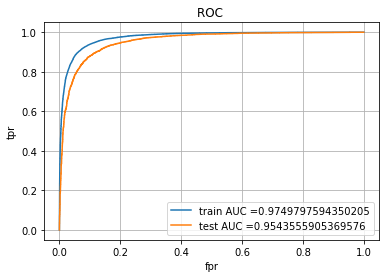

In [48]:
# from above result, we can conclude that best C is 0.1
lr_clf = LogisticRegression(penalty='l2', solver='saga', C=0.1)
lr_clf.fit(train_bow, y_train)

y_train_pred = lr_clf.predict_proba(train_bow)[:,1] 
y_test_pred = lr_clf.predict_proba(test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC ")
plt.grid()
plt.show()



the maximum value of tpr*(1-fpr) 0.8487793539754708 for threshold 0.514
Train confusion matrix


<AxesSubplot:>

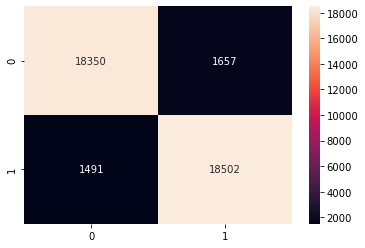

In [49]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
train_confusion_mat = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(train_confusion_mat, annot=True, fmt='d')

Test confusion matrix


<AxesSubplot:>

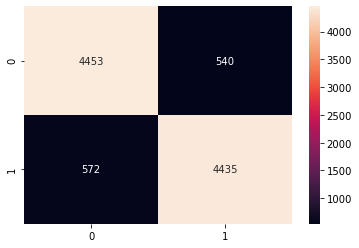

In [50]:
print("Test confusion matrix")
test_confusion_mat = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(test_confusion_mat, annot=True, fmt='d')

In [51]:
print_aprf_scores(y_test, predict_with_best_t(y_test_pred, best_t))

Accuracy: 0.8888
Precision score: 0.8914572864321608
Recall score: 0.8857599360894748
F1 score: 0.8885994790623122


In [52]:
print(f'ROC score: {roc_auc_score(y_test,y_test_pred)}')
print(f'log loss: {log_loss(y_test, predict_with_best_t(y_test_pred, best_t))}')
print(f'brier score loss: {brier_score_loss(y_test, predict_with_best_t(y_test_pred, best_t))}')

ROC score: 0.9543555905369576
log loss: 3.840755113375299
brier score loss: 0.1112
